## 데이터 모델링 연습

In [6]:
import datetime
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Input, Activation, Conv2D, Flatten, Dense, MaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

In [7]:
# 데이터 로드
x_train = np.load('eye_blink_detector-master/dataset/x_train.npy').astype(np.float32)
y_train = np.load('eye_blink_detector-master/dataset/y_train.npy').astype(np.float32)
x_val = np.load('eye_blink_detector-master/dataset/x_val.npy').astype(np.float32)
y_val = np.load('eye_blink_detector-master/dataset/y_val.npy').astype(np.float32)

# 데이터 shape 확인
print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(2586, 26, 34, 1) (2586, 1)
(288, 26, 34, 1) (288, 1)


In [9]:
# 모델링

inputs = Input(shape=(26, 34, 1))

net = Conv2D(32, kernel_size=3, strides=1, padding='same', activation='relu')(inputs)
net = MaxPooling2D(pool_size=2)(net)

net = Conv2D(64, kernel_size=3, strides=1, padding='same', activation='relu')(net)
net = MaxPooling2D(pool_size=2)(net)

net = Conv2D(128, kernel_size=3, strides=1, padding='same', activation='relu')(net)
net = MaxPooling2D(pool_size=2)(net)

net = Flatten()(net)

net = Dense(512)(net)
net = Activation('relu')(net)
net = Dense(1)(net)
outputs = Activation('sigmoid')(net)

model = Model(inputs=inputs, outputs=outputs)

model.compile(optimizer='Rmsprop', loss='binary_crossentropy', metrics=['acc'])

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 26, 34, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 34, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 17, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 17, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 8, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 6, 8, 128)         73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 4, 128)         0     

In [15]:
# 데이터 복제

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(
    x=x_train, y=y_train,
    batch_size=32,
    shuffle=True
)

val_generator = val_datagen.flow(
    x=x_val, y=y_val,
    batch_size=32,
    shuffle=False
)

In [16]:
# 모델 학습

start_time = '20210301'

model.fit_generator(
    train_generator, epochs=20, validation_data=val_generator,
    callbacks=[
        ModelCheckpoint('models/%s.h5' % (start_time), monitor='val_acc', save_best_only=True, mode='max', verbose=1),
        ReduceLROnPlateau(monitor='val_acc', factor=0.2, patience=10, verbose=1, mode='auto', min_lr=1e-05)
    ]
)


C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
81/81 [==============================] - 6s 52ms/step - loss: 0.6066 - acc: 0.6351 - val_loss: 0.2136 - val_acc: 0.9062

Epoch 00001: val_acc improved from -inf to 0.90625, saving model to models\20210301.h5
Epoch 2/20
81/81 [==============================] - 4s 43ms/step - loss: 0.2785 - acc: 0.8943 - val_loss: 0.1137 - val_acc: 0.9792

Epoch 00002: val_acc improved from 0.90625 to 0.97917, saving model to models\20210301.h5
Epoch 3/20
81/81 [==============================] - 4s 47ms/step - loss: 0.2019 - acc: 0.9255 - val_loss: 0.0705 - val_acc: 0.9688

Epoch 00003: val_acc did not improve from 0.97917
Epoch 4/20
81/81 [==============================] - 4s 46ms/step - loss: 0.1595 - acc: 0.9426 - val_loss: 0.1540 - val_acc: 0.9479

Epoch 00004: val_acc did not improve from 0.97917
Epoch 5/20
81/81 [==============================] - 4s 48ms/step - loss: 0.1295 - acc: 0.9565 - val_loss: 0.0355 - val_acc: 0.9931

Epoch 00005: val_acc improved from 0.97917 to 0.99306, saving m

test acc: 0.9965277777777778


<AxesSubplot:>

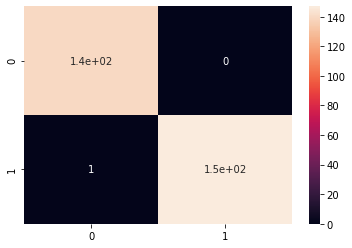

In [17]:
# 정확도 측정, 시각화

from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

model = load_model('models/%s.h5' % (start_time))

y_pred = model.predict(x_val/255.)
y_pred_logical = (y_pred > 0.5).astype(np.int)

print ('test acc: %s' % accuracy_score(y_val, y_pred_logical))
cm = confusion_matrix(y_val, y_pred_logical)
sns.heatmap(cm, annot=True)